In [1]:
using Pkg, CairoMakie, LaTeXStrings
Pkg.activate("/Users/jiyong/.juliaenv/image")
using OpenCV, TestImages
cv = OpenCV;

  Activating project at `~/.juliaenv/image`


In [31]:
function arr2mat(arr::Matrix{T}) where T
    cv.Mat(permutedims(stack([arr, ]), [3,2,1]))
end

function arr2mat(arr::Array{T, 3}) where T
    cv.Mat(arr)
end

function img2arr(img)
    T = typeof(img[1, 1].val.i)
    broadcast(q->T(q.val.i),img)
end

function img2mat(img) 
    T = typeof(img[1, 1].val.i)
    tm = broadcast(q->T(q.val.i),img)
    cv.Mat(permutedims(stack([tm, ]), [3,2,1]))
end

function mat2arr(mat::OpenCV.Mat)
    return permutedims(mat.data, [3,2,1])
end

# function histogram1d(mat::OpenCV.Mat{T}) where T<:Union{UInt8, UInt16}
#     tm = Int32(typemax(T))
#     v = cv.calcHist(cv.InputArray[mat,], Int32[0], fill(UInt8(1), size(img1)), Int32[tm+1], Float32[0, tm+1])
#     return (0:1:tm, Int64.(v[1,1,:]))    
# end

function histogram1d(mat::OpenCV.Mat{T}) where T<:Union{UInt8, UInt16}
    tm = Int32(typemax(T))

    v = cv.calcHist(cv.InputArray[mat,], Int32[0], fill(UInt8(1), size(mat)), Int32[tm+1], Float32[0, tm+1])
    return (0:1:tm, Int64.(v[1,1,:]))    
end



# img0= testimage_dip3e("Fig0108(a) (corn-fluorescence).tif")
# img1 = img2arr(img0)
# img2 = (UInt8(255) .- img1)
# r = arr2mat(cat(img1, img2;dims=2))
# cv.imwrite("inversion.jpg", r)

histogram1d (generic function with 1 method)

In [32]:
img0= testimage_dip3e("Fig0227(a)(washington_infrared).tif")
img1 = cv.resize(img2mat(img0), cv.Size{Int32}(256, 256))
img2 = arr2mat(round.(UInt8, ((img1./255).^0.5)*255))
img3 = arr2mat(round.(UInt8, ((img1./255).^2)*255))
img4 = arr2mat(round.(UInt8, ((img1./255).^5)*255));

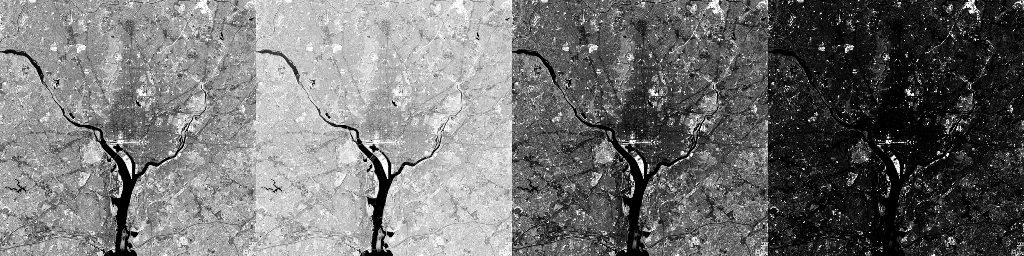

In [34]:
arr2mat(cat(img1, img2, img3, img4; dims=2))

In [35]:
cv.Point(Int32(0), Int32(100))

OpenCV.Point{Int32}(0, 100)

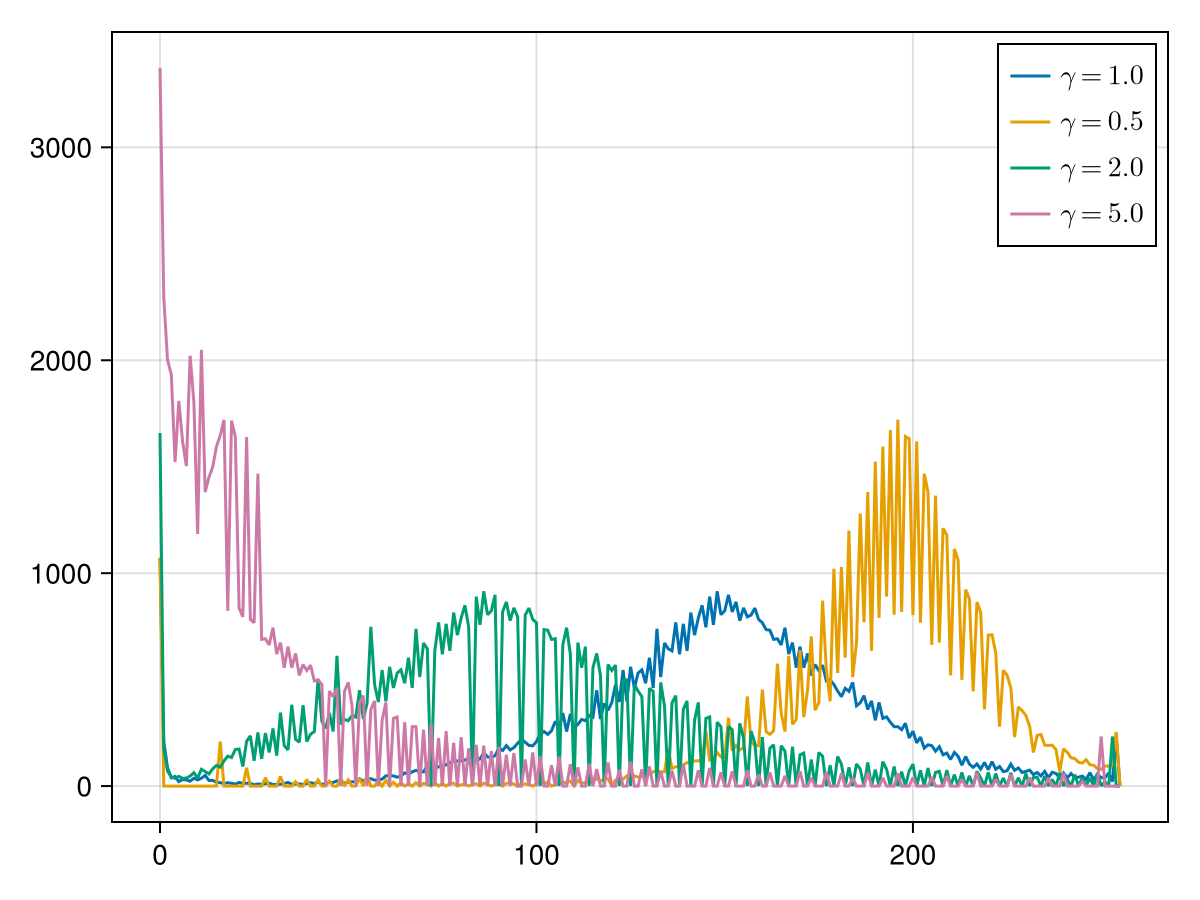

In [36]:
fig = Figure()
ax = Axis(fig[1,1])
for (img, g) in zip([img1, img2, img3, img4], [1.0, 0.5, 2, 5])
    b, v = histogram1d(img)
    lines!(ax, b, v, label = L"\gamma = %$g")
end
axislegend()
fig

In [8]:
#save("histogram_gamma.png", fig)

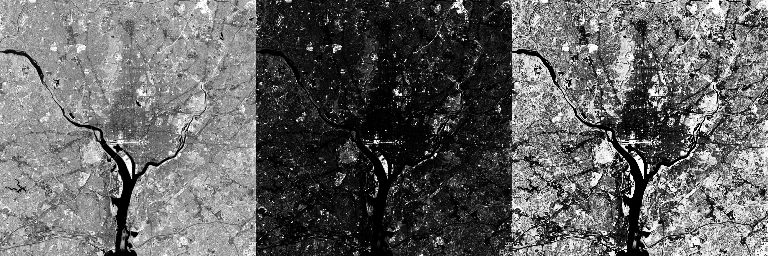

In [10]:
img5 = cv.equalizeHist(img4)
s = arr2mat(cat(img1, img4, img5; dims=2))
# cv.imwrite("equalize_histogram_1.png", s)

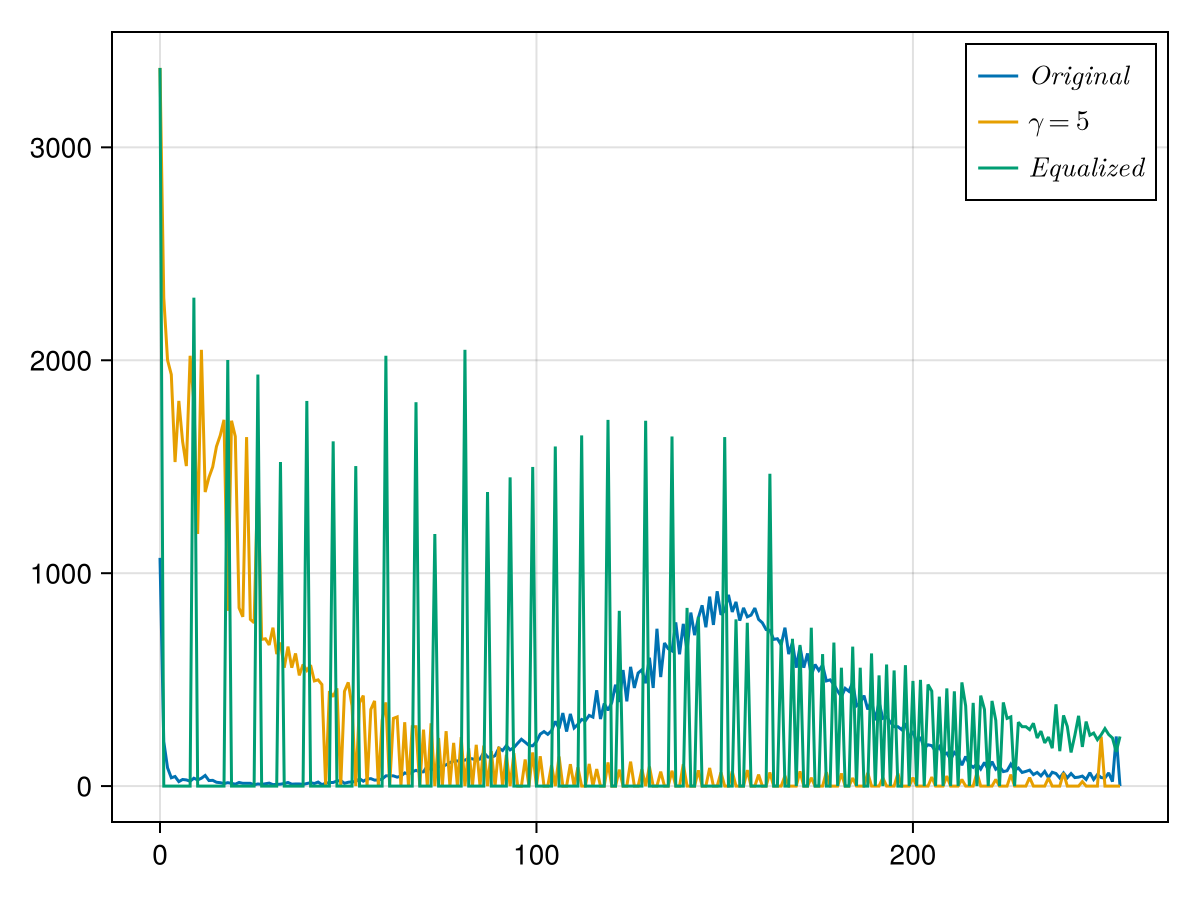

In [11]:
fig = Figure()
ax = Axis(fig[1,1])
for (img, g) in zip([img1, img4, img5], ["Original", "\\gamma=5", "Equalized"])
    b, v = histogram1d(img)
    lines!(ax, b, v, label = L"%$g")
end
axislegend()
fig
#save("equalize_histogram.png", fig)

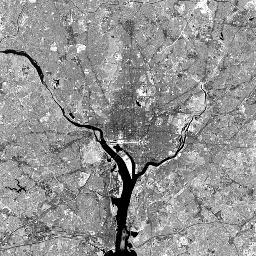

In [12]:
img1

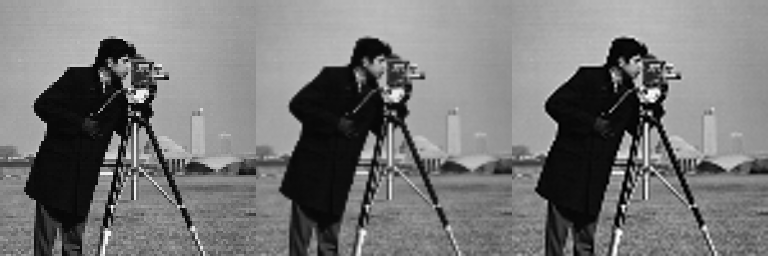

In [13]:
img0= cv.resize(img2mat(testimage("cameraman.tif")), cv.Size{Int32}(100, 100))
img1 = cv.resize(img0, cv.Size(Int32(256), Int32(256));interpolation= cv.INTER_NEAREST)
img2 = cv.resize(img0, cv.Size(Int32(256), Int32(256));interpolation= cv.INTER_LINEAR)
img3 = cv.resize(img0, cv.Size(Int32(256), Int32(256));interpolation= cv.INTER_CUBIC)
s = arr2mat(cat(img1, img2, img3; dims=2))
#cv.imwrite("interpolation.png", s)

In [39]:
img0= img2mat(testimage("cameraman.tif"))

using Distributions
function gaussian_noise(img::OpenCV.Mat{T}, μ, σ, N) where T<:Union{UInt8, UInt16}
    m, n = size(img)[2:3]
    MM = typemax(T)
    Y, X, V = rand(1:m, N), rand(1:n, N), round.(T, rand(truncated(Normal(μ, σ), 0, MM), N))
    img2 = copy(img)
    for (y, x, v) ∈ zip(Y, X, V)
        img2[1, y, x] = v
    end
    return img2
end

function salt_pepper_noise(img::OpenCV.Mat{T}, N) where T<:Union{UInt8, UInt16}
    m, n = size(img)[2:3]
    MM = typemax(T)
    Y, X, V = rand(1:m, N), rand(1:n, N), sample([0, MM], N)
    img2 = copy(img)
    for (y, x, v) ∈ zip(Y, X, V)
        img2[1, y, x] = v
    end
    return img2
end


salt_pepper_noise (generic function with 1 method)

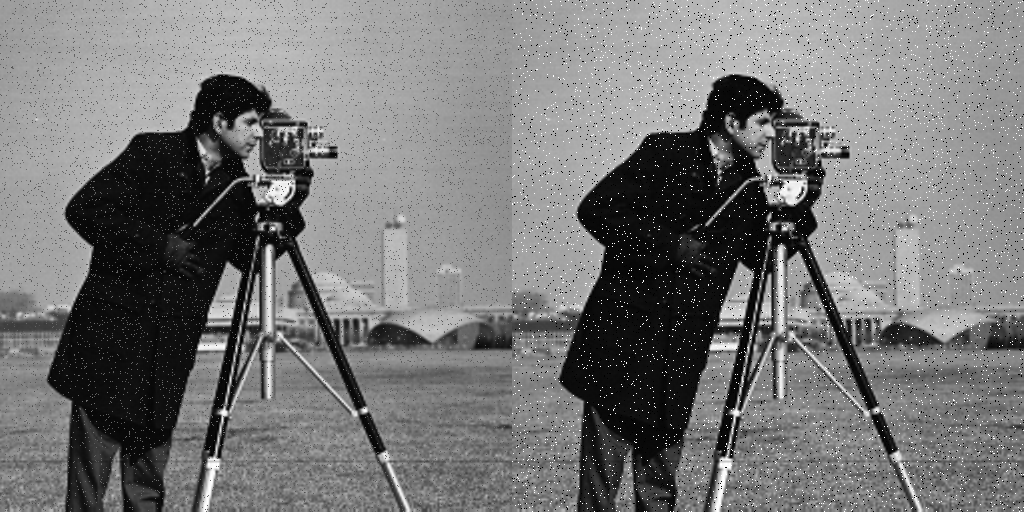

In [58]:
img_gn = gaussian_noise(img0, 100, 10, 10000)
img_sp = salt_pepper_noise(img0, 10000)
img2=arr2mat(cat([img_gn img_sp]; dims=2))

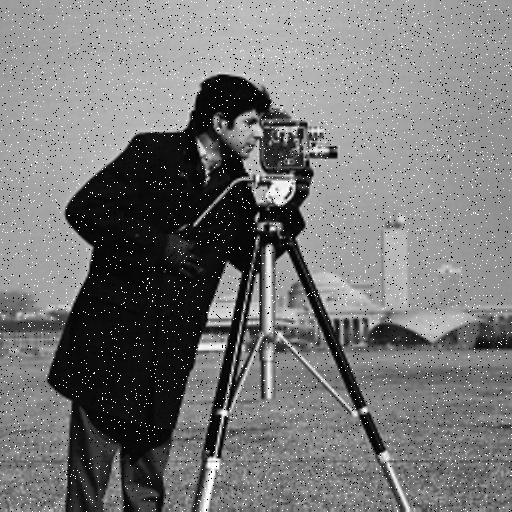

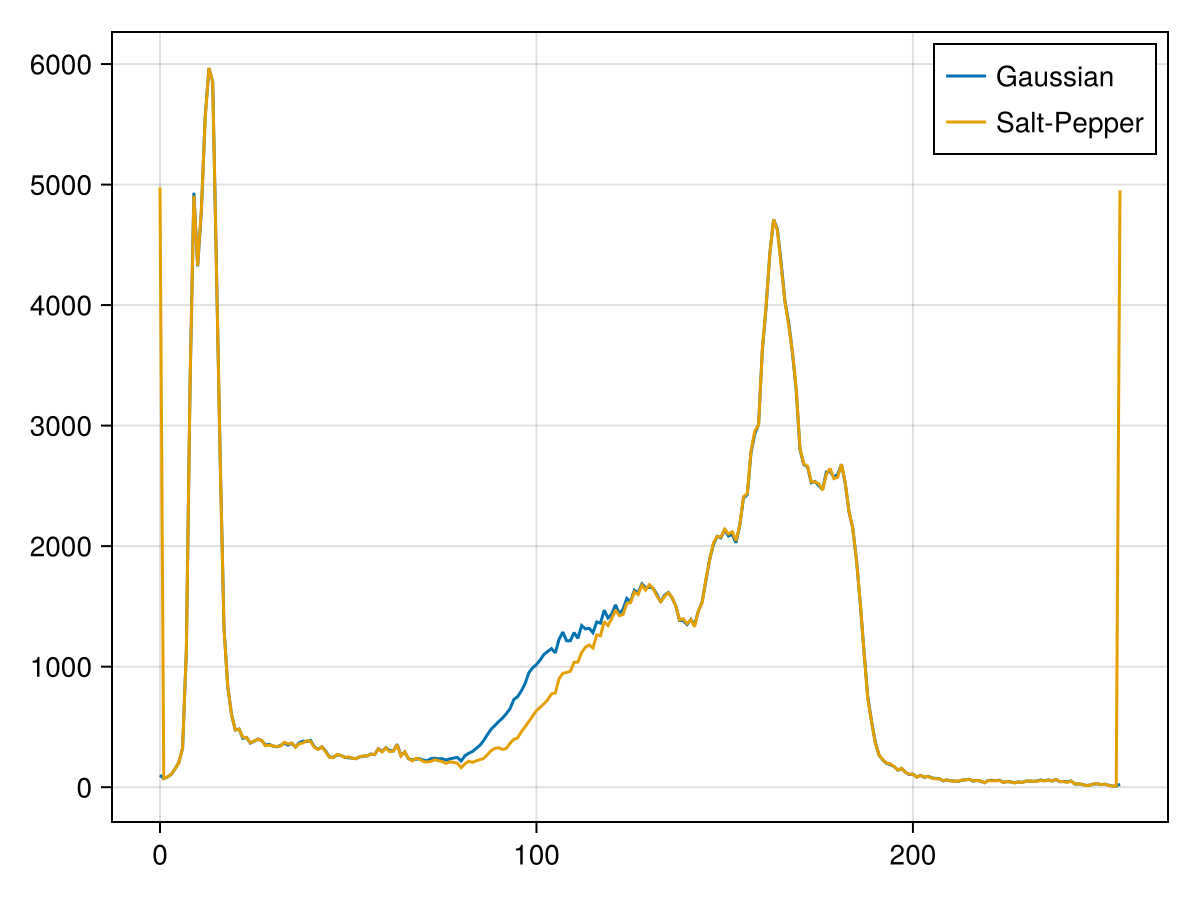

In [60]:
fig = Figure()
ax = Axis(fig[1,1])
for (img, g) in zip([img_gn, img_sp], ["Gaussian", "Salt-Pepper"])
    b, v = histogram1d(img)
    lines!(ax, b, v, label = "$g")
end
axislegend()
fig
#save("noise_histogram.png", fig)


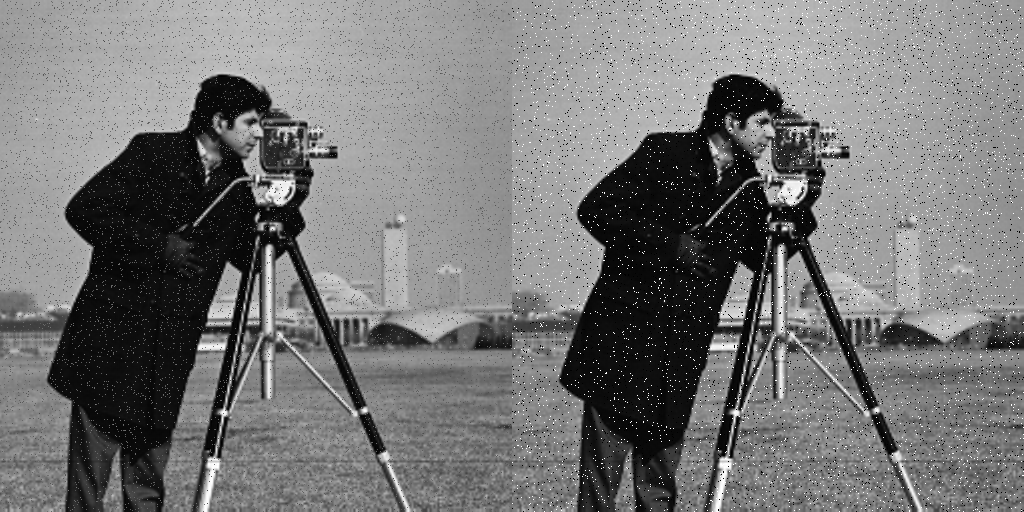

In [ ]:
function conv2d(img, ker)
    m, n = size(A)
    p, q = size(k)
    @assert isodd(p) && isodd(q)
    c, d = p>>1, q>>1
    
    R = zero(img)

    dx, dy = div(p,2), div(q, 2)
    for j ∈ (dx+1):(m-dx), i ∈ (dy+1):(n-dy)
        
        for t ∈ 1:q, s ∈ 1:p
            R[i, j] += ker[s, t] * img[i-(s-c-1), j-(t-d-1)]
        end
    end

    return R[dy+1:end-dy, dx+1:end-dx]
end

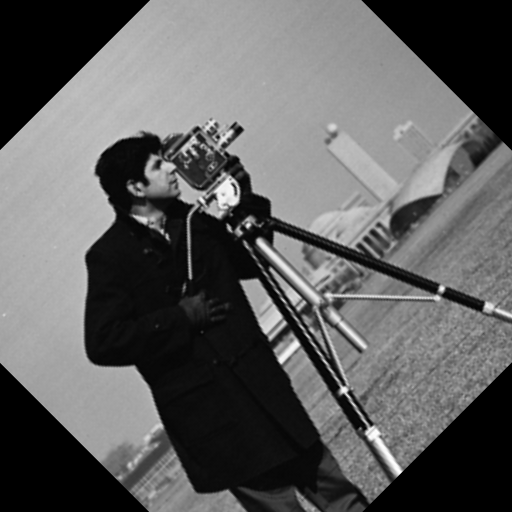

In [77]:

h, w = Int32.(size(img0)[2:3])
cX, cY = Float32(h/2), Float32(w/2)
M = cv.getRotationMatrix2D(cv.Point(cX, cY), 45.0, 1.0)
rotated_45 = cv.warpAffine(img0, M, cv.Size(w, h))

In [85]:
mat2arr(cv.getRotationMatrix2D(cv.Point(cX, cY), 45.0, 1.0))

2×3×1 Array{Float64, 3}:
[:, :, 1] =
  0.707107  0.707107  -106.039
 -0.707107  0.707107   256.0

In [84]:
mat2arr(cv.getRotationMatrix2D(cv.Point(cX, cY), 0.0, 1.0))

2×3×1 Array{Float64, 3}:
[:, :, 1] =
  1.0  0.0  0.0
 -0.0  1.0  0.0

In [87]:
typeof(cv.getRotationMatrix2D(cv.Point(cX, cY), 45.0, 1.0))

OpenCV.Mat{Float64}

In [88]:
size(cv.getRotationMatrix2D(cv.Point(cX, cY), 45.0, 1.0))

(1, 3, 2)

In [118]:
M2=arr2mat(Float32.([1/√2 1/√2 -256; -1/√2 1/√2 -256]))

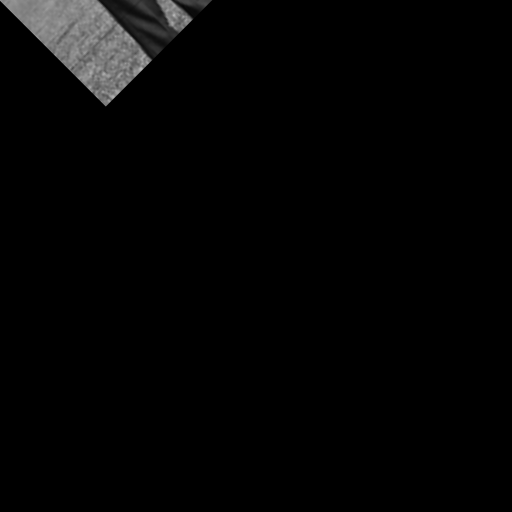

In [119]:
cv.warpAffine(img0, M2, cv.Size(w, h))

In [127]:
T1=Float32[1 0 -256; 0 1 -256; 0 0 1]
T2=(Float32.([1/√2 1/√2 0; -1/√2 1/√2 0;0 0 1 ]))
T3=Float32[1 0 256; 0 1 256; 0 0 1]

3×3 Matrix{Float32}:
 1.0  0.0  256.0
 0.0  1.0  256.0
 0.0  0.0    1.0

In [128]:
T3*T2*T1

3×3 Matrix{Float32}:
  0.707107  0.707107  -106.039
 -0.707107  0.707107   256.0
  0.0       0.0          1.0